In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import os
import matplotlib.pyplot as plt
import seaborn as sns

P+ = pegar georreferenciamto das contribuições por subs e fazer um mapa de calor por subprefeitura com a quantidade de contribuições. Mapa de calor da quantidade de contribuições por subprefeitura de moradia do municipe

base de dados audieências - mapa de calor das contribuições por audiência regional. Usar coluna de ID da audiência - se for menos que 36

grafico de barras por canal de partipação (P+, Audiências Regionais, Audiências Temáticas, Ofícios).

das sugestões = mapa de calor com quantidade de sugestões por subprefeitura

grafico de sugestões por tema (depois do de-para)

Grafico ou tabela que mostre, para cada subprefeitura, o tema que mais apareceu


(tudo que for por tema eu vou deixar pronto por secretaria)

In [2]:
%matplotlib inline
sns.set_theme("notebook", style = 'whitegrid', rc = {'axes.grid' : False,
                                                    'figure.figsize':(11.7,8.27)})

### Dados sistematização

In [3]:
path_dados = '../Dados_originais/Base_Dados_Sepep/Base de dados 20210526 2000.xlsx'
municipes = pd.read_excel(path_dados, sheet_name = 'Munícipe')
sugestoes = pd.read_excel(path_dados, sheet_name = 'Sugestão')
contribuicoes = pd.read_excel(path_dados, sheet_name = 'Contribuição Integral')

C:\Users\h-pgy\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [4]:
def drop_empty_cols(df):
    
    df = df.copy()
    cols_empty = [col for col, val in 
                  df.isnull().all().to_dict().items() 
                  if val]
    print(cols_empty)
    
    df.drop(cols_empty, axis = 1, inplace=True)
    
    return df

In [5]:
municipes = drop_empty_cols(municipes)
sugestoes = drop_empty_cols(sugestoes)
contribuicoes =  drop_empty_cols(contribuicoes)

[]
['Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']
['Apoio P+', 'Unnamed: 5']


### Criar coluna categorias

In [6]:
de_para_sec_cat = {
    'CET' : 'Transportes e Mobilidade',
    'CGM' : 'Outros temas',
    'SECOM' : 'Outros temas',
    'SEHAB' : 'Habitação',
    'SEME' : 'Esporte e Lazer',
    'SF' : 'Outros temas',
    'SGM' : 'Outros temas',
    'SIURB' : 'Infraestrutura Urbana e Obras',
    'SMADS' : 'Assistência Social',
    'SMC' : 'Cultura',
    'SMDET' : 'Desenvolvimento Econômico e Trabalho',
    'SMDHC' : 'Direitos Humanos e Cidadania',
    'SME' : 'Educação',
    'SMIT' : 'Inovação e Tecnologia',
    'SMPED' : 'Pessoa com Deficiência',
    'SMRI' : 'Outros temas',
    'SMS' : 'Saúde',
    'SMSU' : 'Segurança Urbana',
    'SMSUB' : 'Zeladoria Urbana e melhorias de bairro',
    'SMT' : 'Transportes e Mobilidade',
    'SMUL' : 'Urbanismo e Licenciamento',
    'SP-Obras' : 'Infraestrutura Urbana e Obras',
    'SVMA' : 'Meio Ambiente'
}

In [7]:
sugestoes['Categoria'] = sugestoes['Sec Ajustado'].apply(lambda x: de_para_sec_cat.get(x, 'Null'))

### Filtrando apenas audiencias

In [8]:
municipes['audiencia_num'] = municipes['Municipe ID'].apply(lambda x: int(str(x).split('.')[0]) if not pd.isnull(x) else None)
municipes_audiencias = municipes[municipes['audiencia_num']<=36].reset_index(drop=True).copy()
set(municipes_audiencias['audiencia_num'].astype(int).astype(str)+ ' : ' + municipes_audiencias['Subprefeitura Origem'])

{'1 : Geral',
 '10 : Santana',
 '11 : V Maria V Guilherme',
 '12 : Capela do Socorro',
 '13 : Parelheiros',
 '14 : Cidade Ademar',
 '15 : Santo Amaro',
 '16 : Jabaquara',
 '17 : Vila Mariana',
 '18 : Ipiranga',
 '19 : Butantã',
 '2 : Lapa',
 '20 : Campo Limpo',
 "21 : M'Boi Mirim",
 "22 : M'Boi Mirim",
 '23 : São Miguel',
 '24 : Temática 1',
 '25 : Temática 2',
 '26 : Temática 3',
 '27 : Itaim Paulista',
 '28 : Guaianases',
 '29 : Mooca',
 '3 : Sé',
 '30 : Penha',
 '31 : Vila Prudente',
 '32 : Aricanduva',
 '33 : Sapopemba',
 '34 : Itaquera',
 '35 : São Mateus',
 '36 : Cidade Tiradentes',
 '4 : Pinheiros',
 '5 : Casa Verde',
 '6 : Freguesia',
 '7 : Perus',
 '8 : Pirituba/Jaraguá',
 '9 : Jaçanã/ Tremenbé '}

In [9]:
contribuicoes['audiencia_num'] = contribuicoes['Municipe ID'].apply(lambda x: int(str(x).split('.')[0]) if not pd.isnull(x) else None)
contribuicoes_audiencias = contribuicoes[contribuicoes['audiencia_num']<=36].reset_index(drop=True).copy()
set(contribuicoes_audiencias['audiencia_num'].astype(int).astype(str)+ ' : ' + contribuicoes_audiencias['Sub Origem'])

{'10 : Santana',
 '11 : V Maria V Guilherme',
 '12 : Capela do Socorro',
 '13 : Parelheiros',
 '14 : Cidade Ademar',
 '15 : Santo Amaro',
 '16 : Jabaquara',
 '17 : Vila Mariana',
 '18 : Ipiranga',
 '19 : Butantã',
 '2 : Lapa',
 '20 : Campo Limpo',
 "21 : M'Boi Mirim",
 "22 : M'Boi Mirim",
 '23 : São Miguel',
 '27 : Itaim Paulista',
 '28 : Guaianases',
 '29 : Mooca',
 '3 : Sé',
 '30 : Penha',
 '32 : Aricanduva',
 '33 : Sapopemba',
 '34 : Itaquera',
 '35 : São Mateus',
 '36 : Cidade Tiradentes',
 '4 : Pinheiros',
 '5 : Casa Verde',
 '6 : Freguesia',
 '7 : Perus',
 '8 : Pirituba/Jaraguá',
 '9 : Jaçanã',
 nan}

In [10]:
sugestoes['Contribuição ID']

0       C10.1
1       C10.1
2       C10.1
3       C10.2
4       C10.2
        ...  
4075     1068
4076     1069
4077     1070
4078     1071
4079     1072
Name: Contribuição ID, Length: 4080, dtype: object

#### Shapefiles Geosampa

In [11]:
subs = gpd.read_file('mapas_geosampa/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp')
municipios = gpd.read_file('mapas_geosampa/SIRGAS_SHP_limites_municipais/SIRGAS_limites_municipais.shp')

In [12]:
subs.crs = {'init': 'epsg:4674'}
municipios.crs = {'init': 'epsg:4674'}

In [13]:
#arrumar o tipo de uma coluna que veio errado
subs['sp_id'] = subs['sp_id'].apply(int)

### Acrescentar informação subs para dados sistematização

In [14]:
de_para_subs = { 
        'Aricanduva' : 'ARICANDUVA-FORMOSA-CARRAO',
        'Butantã' : 'BUTANTA',
        'Campo Limpo' : 'CAMPO LIMPO',
        'Capela do Socorro' : 'CAPELA DO SOCORRO',
        'Casa Verde' : 'CASA VERDE-CACHOEIRINHA',
        'Cidade Ademar' : 'CIDADE ADEMAR',
        'Cidade Tiradentes' : 'CIDADE TIRADENTES',
        'Ermelino Matarazzo' : 'ERMELINO MATARAZZO',
        'Freguesia' : 'FREGUESIA-BRASILANDIA',
        'Guaianases' : 'GUAIANASES',
        'Ipiranga' : 'IPIRANGA',
        'Itaim Paulista' : 'ITAIM PAULISTA',
        'Itaquera' : 'ITAQUERA',
        'Jabaquara' : 'JABAQUARA',
        'Jaçanã' : 'JACANA-TREMEMBE',
        'Jaçanã/ Tremenbé ' : 'JACANA-TREMEMBE',
        'Lapa' : 'LAPA',
        "M'Boi Mirim" : "M'BOI MIRIM",
        'Mooca' : 'MOOCA',
        'Parelheiros' : 'PARELHEIROS', 
        'Penha' : 'PENHA',
        'Perus' : 'PERUS',
        'Pinheiros' : 'PINHEIROS',
        'Pirituba/Jaraguá' : 'PIRITUBA-JARAGUA',
        'Santana' : 'SANTANA-TUCURUVI',
        'Santo Amaro' : 'SANTO AMARO',
        'São Mateus' : 'SAO MATEUS',
        'São Miguel' : 'SAO MIGUEL',
        'Sapopemba' : 'SAPOPEMBA',
        'Sé' : 'SE',
        'V Maria/V Guilherme' : 'VILA MARIA-VILA GUILHERME',
        'V Maria V Guilherme' : 'VILA MARIA-VILA GUILHERME',
        'Vila Mariana' : 'VILA MARIANA',
        'Vila Prudente' : 'VILA PRUDENTE',
        'Temática 3' : 'Supraregional',
        'Temática 2' : 'Supraregional',
        'Temática 1' : 'Supraregional',
        'Geral' : 'Supraregional'

    }

In [15]:
def padronizar_subs(df, col_subs, de_para_subs):
    
    df = df.copy()
    
    df['subs_padrao'] = df[col_subs].apply(
        lambda x: de_para_subs[x] if x in de_para_subs else 'Não Identificado')
    
    print(df[df['subs_padrao']=='Não identificado'][col_subs].unique())
    
    return df

In [16]:
sugestoes = padronizar_subs(sugestoes, 'Sub Final', de_para_subs)

[]


In [17]:
contribuicoes_audiencias = padronizar_subs(contribuicoes_audiencias, 'Sub Origem', de_para_subs)

[]


In [18]:
contribuicoes = padronizar_subs(contribuicoes, 'Sub Origem', de_para_subs)

[]


In [19]:
municipes_audiencias = padronizar_subs(municipes_audiencias, 'Subprefeitura Origem', de_para_subs)

[]


In [20]:
def add_count_col(df):
    
    df = df.copy()
    df['count'] = 1
    
    return df

In [21]:
sugestoes = add_count_col(sugestoes)
contribuicoes = add_count_col(contribuicoes)
municipes_audiencias = add_count_col(municipes_audiencias)

In [22]:
def qtd_registros_por_subs(df):
    
    qtd_reg_subs = df.groupby('subs_padrao').count()\
                ['count'].to_dict()
    
    return qtd_reg_subs

In [23]:
def add_qtd_reg_col(df_subs, new_col, qtd_reg_dict):
    
    df_subs = df_subs.copy()
    
    df_subs[new_col] = df_subs['sp_nome'].apply(lambda x: qtd_reg_dict.get(x, 0))
    
    return df_subs

In [24]:
qtd_sugestoes_subs = qtd_registros_por_subs(sugestoes)

In [25]:
qtd_contribs_subs = qtd_registros_por_subs(contribuicoes)

In [26]:
qtd_municip_audiencias = qtd_registros_por_subs(municipes_audiencias)

In [27]:
subs = add_qtd_reg_col(subs, 'qtd_sugestoes', qtd_sugestoes_subs)
subs = add_qtd_reg_col(subs, 'qtd_contribuicoes', qtd_contribs_subs)
subs = add_qtd_reg_col(subs, 'qtd_municipes_audiencias', qtd_municip_audiencias)
subs = add_qtd_reg_col(subs, 'qtd_contribuicoes_audiencias', qtd_municip_audiencias)

In [28]:
subs.sample(3)

,sp_codigo,sp_nome,sp_id,geometry,qtd_sugestoes,qtd_contribuicoes,qtd_municipes_audiencias,qtd_contribuicoes_audiencias
6,24,ITAIM PAULISTA,10,"POLYGON ((356442.867 7397206.644, 356438.305 7...",107,13,13,13
22,32,SAPOPEMBA,32,"POLYGON ((346342.902 7386377.742, 346340.397 7...",96,20,20,20
27,05,SANTANA-TUCURUVI,4,"POLYGON ((334167.487 7398040.229, 334086.710 7...",51,10,10,10


### Plotar mapas dados sistematização

In [29]:
def cmap_plot(geodf, col, title, f_name = None, path='mapas_subprefeituras'):
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    ax = geodf.plot(column=col, cmap = 'GnBu',
                legend_kwds={'label': "Quantidade",
                             'orientation': "vertical"},
               legend=True,
               figsize = (10, 15))
    
    ax.set_title(title,
                fontsize=18)
    plt.axis('off')
    
    fig = ax.get_figure()
    
    if f_name is None:
        f_name = title+'.png'
    
    fig.savefig(os.path.join(path, f_name))

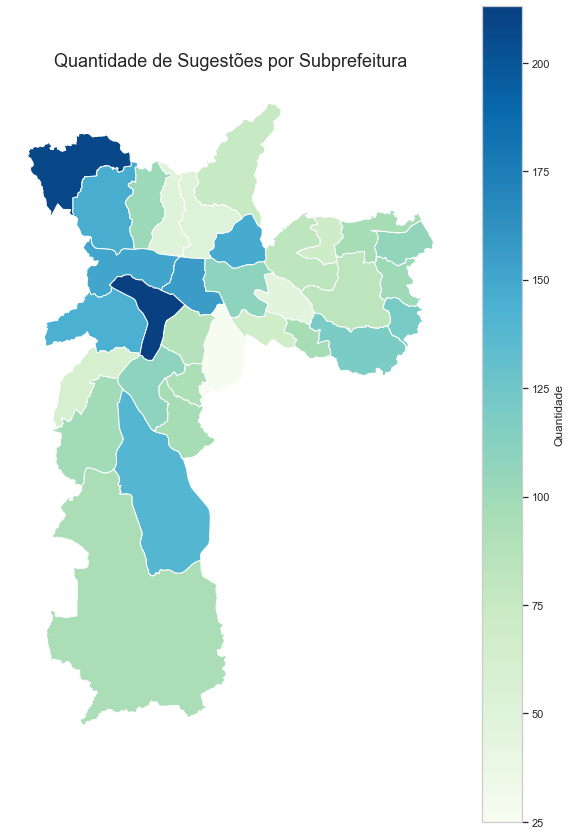

In [30]:
cmap_plot(subs, 'qtd_sugestoes', 'Quantidade de Sugestões por Subprefeitura')

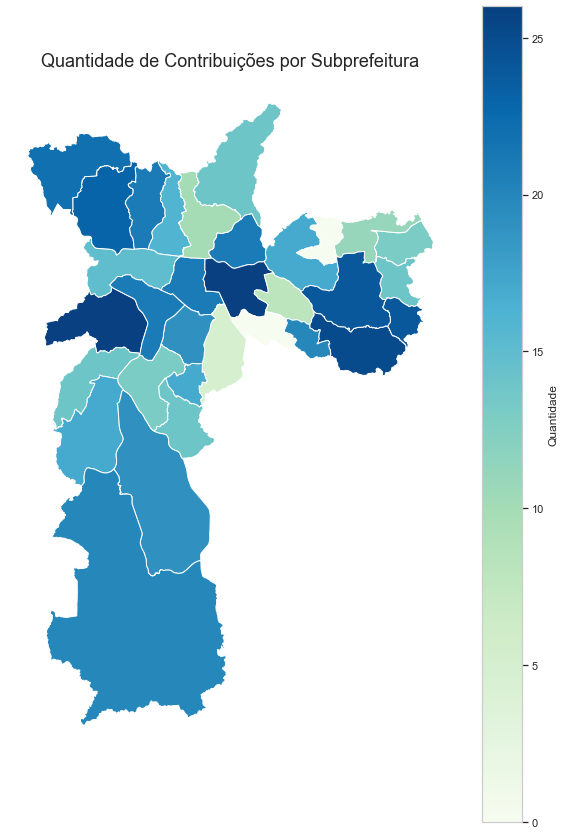

In [31]:
cmap_plot(subs, 'qtd_contribuicoes', 'Quantidade de Contribuições por Subprefeitura')

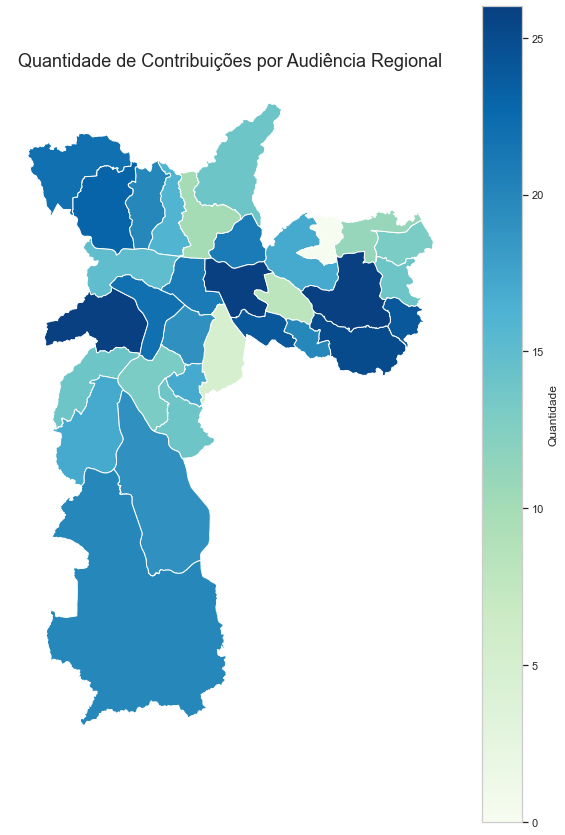

In [32]:
cmap_plot(subs, 'qtd_contribuicoes_audiencias', 'Quantidade de Contribuições por Audiência Regional')

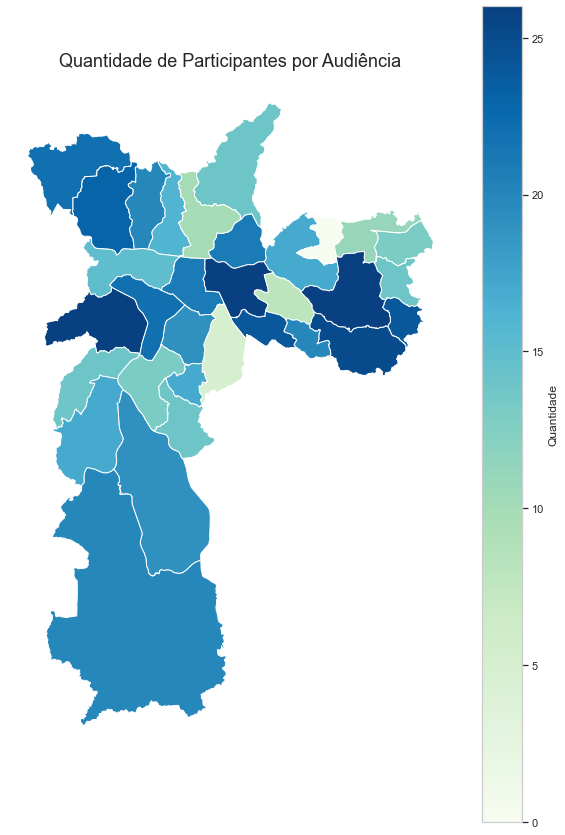

In [33]:
cmap_plot(subs, 'qtd_municipes_audiencias', 'Quantidade de Participantes por Audiência')

### Categoria/Secretaria por subprefeitura

In [34]:
sugs_por_subs_por_sec = sugestoes.groupby(['subs_padrao', 'Secretaria']).count()[['count']].copy()

In [35]:
sugs_por_subs_por_sec.to_excel("planilha_secretarias_por_subprefeitura.xlsx")

In [36]:
def plot_qtd(data, y):
    
    mapa = sns.countplot(y=y, data=data, color = 'steelblue',
                       order = data[y].value_counts().index)
    return mapa

In [37]:
def plot_qtd_per_sub(df, subprefeitura, path, title = 'quantidade de sugestões', y = 'Secretaria'):
    
    data= df[df['subs_padrao']==subprefeitura]
    mapa = plot_qtd(data, y)
    mapa.set_title(f'{subprefeitura} - {title}')
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    f_name = f'{subprefeitura} - {title}.png'
    f_path = os.path.join(path, f_name)
    mapa.figure.savefig(f_path, bbox_inches='tight')
    plt.clf()

In [38]:
for subprefeitura in sugestoes['subs_padrao'].unique():
    plot_qtd_per_sub(sugestoes, subprefeitura, path = 'graficos_qtd_sec_per_sub')

<Figure size 842.4x595.44 with 0 Axes>

In [39]:
sugs_por_subs_por_cat = sugestoes.groupby(['subs_padrao', 'Categoria']).count()[['count']].copy()

In [40]:
sugs_por_subs_por_cat.to_excel("planilha_categorias_por_subprefeitura.xlsx")

In [41]:
for subprefeitura in sugestoes['subs_padrao'].unique():
    plot_qtd_per_sub(sugestoes, subprefeitura, y = 'Categoria', path = 'graficos_qtd_cat_per_sub')

<Figure size 842.4x595.44 with 0 Axes>

### Grafico contribuicoes por canal e sugestoes por tema

In [42]:
contribuicoes['id_canal'] = contribuicoes['Contribuição ID'].apply(lambda x: 
                                                                   int(str(x).split('.')[0]) if not pd.isnull(x) else None)

In [43]:
de_para_canais = pd.read_excel(path_dados, sheet_name = 'ID e lista suspensa')[['Municipe', 'Unnamed: 1']].drop(0).rename(
                    {'Municipe' : 'id', 'Unnamed: 1' : 'Canal'}, axis =1).replace('\xa0', np.NaN).dropna().set_index('id')['Canal'].to_dict()

In [44]:
de_para_canais

{1.0: 'Geral',
 2.0: 'Lapa',
 3.0: 'Sé',
 4.0: 'Pinheiros',
 5.0: 'Casa Verde',
 6.0: 'Freguesia',
 7.0: 'Perus',
 8.0: 'Pirituba/Jaraguá',
 9.0: 'Jaçanã',
 10.0: 'Santana',
 11.0: 'V Maria V Guilherme',
 12.0: 'Capela do Socorro',
 13.0: 'Parelheiros',
 14.0: 'Cidade Ademar',
 15.0: 'Santo Amaro',
 16.0: 'Jabaquara',
 17.0: 'Vila Mariana',
 18.0: 'Ipiranga',
 19.0: 'Butantã',
 20.0: 'Campo Limpo',
 21.0: "M'Boi Mirim",
 22.0: 'Ermelino Matarazzo',
 23.0: 'São Miguel',
 24.0: 'Temática 1 (SP Justa e Inclusiva)',
 25.0: 'Temática 2 (SP Ágil  + SP  Segura e Bem Cuidada)',
 26.0: 'Temática 3 (SP Eficiente + SP Global e Sustentável + SP Inovadora e Criativa)',
 27.0: 'Itaim Paulista',
 28.0: 'Guaianases',
 29.0: 'Mooca',
 30.0: 'Penha',
 31.0: 'Vila Prudente',
 32.0: 'Aricanduva',
 33.0: 'Sapopemba',
 34.0: 'Itaquera',
 35.0: 'São Mateus',
 36.0: 'Cidade Tiradentes',
 37.0: 'Participe+',
 38.0: 'Documento'}

In [45]:
def aux_canal(id_canal, de_para_canais):
    
    if not pd.isnull(id_canal):
        try:
            canal = de_para_canais[id_canal]
            if canal == 'Geral':
                return "Audiência Pública Geral"
            elif canal.startswith('Temaática'):
                return "Audiências Temáticas"
            elif canal == 'Participe+':
                return "Portal Participe+"
            elif canal == 'Documento':
                return "Ofícios e outros docs."
            else:
                return 'Audiênca Pública Regional'
        except KeyError as e:
            print(id_canal)
            raise(e)
    else:
        return None

In [46]:
contribuicoes['canal_padronizado'] = contribuicoes['id_canal'].apply(lambda x: aux_canal(x, de_para_canais))

In [47]:
def plotar_contrib_por_canal(contribuicoes, path = 'outros_graficos'):
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    
    mapa = plot_qtd(contribuicoes, 'canal_padronizado')
    mapa.set_title('Contribuições por canal de participação', fontsize = 20)
    mapa.set(xlabel='Qtd.', ylabel='Canal de participação')
    mapa.figure.savefig(os.path.join(path, 'contrib_canal_participe.png'))
    plt.clf()

In [48]:
plotar_contrib_por_canal(contribuicoes)

<Figure size 842.4x595.44 with 0 Axes>

In [49]:
def plotar_sugestoes_por_secretaria(sugestoes, path = 'outros_graficos'):
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    
    mapa = plot_qtd(sugestoes, 'Secretaria')
    mapa.set_title('Sugestões por secretaria', fontsize = 20)
    mapa.set(xlabel='Qtd.', ylabel='Secretaria')
    mapa.figure.savefig(os.path.join(path, 'sugestoes_por_secretaria.png'), 
                       bbox_inches='tight')
    plt.clf()

In [50]:
plotar_sugestoes_por_secretaria(sugestoes)

<Figure size 842.4x595.44 with 0 Axes>

In [51]:
def plotar_sugestoes_por_categoria(sugestoes, path = 'outros_graficos'):
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    
    mapa = plot_qtd(sugestoes, 'Categoria')
    mapa.set_title('Sugestões por categoria', fontsize = 20)
    mapa.set(xlabel='Qtd.', ylabel='Categoria')
    mapa.figure.savefig(os.path.join(path, 'sugestoes_por_categoria.png'),
                       bbox_inches='tight')
    plt.clf()

In [52]:
plotar_sugestoes_por_categoria(sugestoes)

<Figure size 842.4x595.44 with 0 Axes>

In [53]:
def plotar_sugestoes_por_subprefeitura(sugestoes, path = 'outros_graficos'):
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    
    mapa = plot_qtd(sugestoes, 'subs_padrao')
    mapa.set_title('Sugestões por subprefeitura', fontsize = 20)
    mapa.set(xlabel='Qtd.', ylabel='Subprefeitura')
    mapa.figure.savefig(os.path.join(path, 'sugestoes_por_subprefeitura.png'),
                       bbox_inches='tight')
    plt.clf()

In [54]:
plotar_sugestoes_por_subprefeitura(sugestoes)

<Figure size 842.4x595.44 with 0 Axes>

### Mapas Participe+

In [55]:
propostas = pd.read_excel('../Dados_gerados/Propostas_georreferenciadas_final.xlsx')
revisoes = pd.read_excel('../Dados_gerados/Revisoes_georreferenciadas_final.xlsx')

In [56]:
propostas['count'] = 1
revisoes['count'] = 1

In [57]:
propos_por_sub = propostas.groupby('subprefeitura').count()['count'].to_dict()
revis_por_sub = revisoes.groupby('subprefeitura').count()['count'].to_dict()

In [58]:
subs['qtd_propostas_participe'] = subs['sp_nome'].apply(lambda x: propos_por_sub.get(x, 0))

In [59]:
subs['qtd_revisoes_participe'] = subs['sp_nome'].apply(lambda x: revis_por_sub.get(x, 0))

In [60]:
subs['qtd_participe_mais_total'] = subs['qtd_propostas_participe'] + subs['qtd_revisoes_participe']

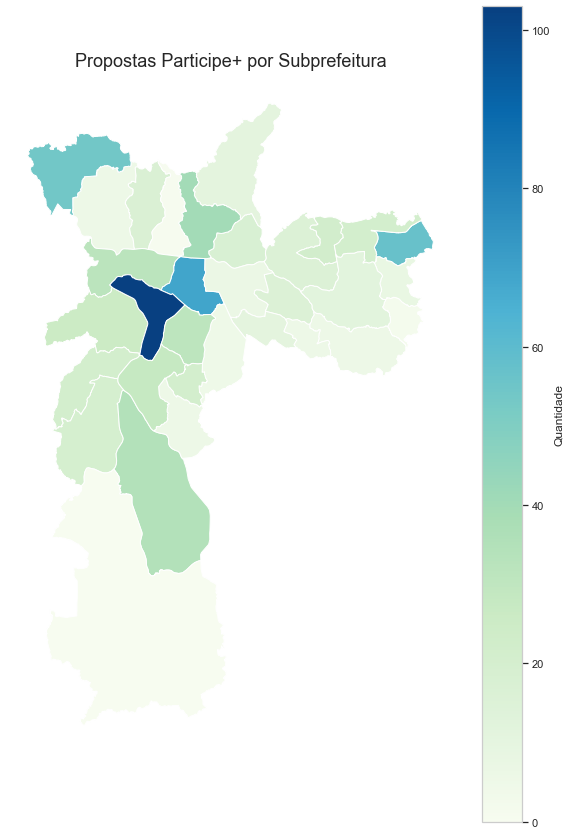

In [61]:
cmap_plot(subs, 'qtd_propostas_participe', 'Propostas Participe+ por Subprefeitura')

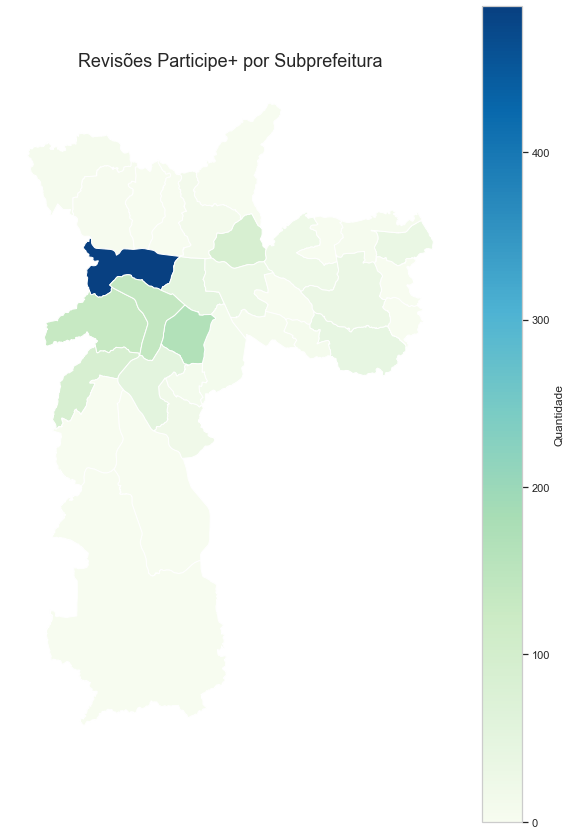

In [62]:
cmap_plot(subs, 'qtd_revisoes_participe', 'Revisões Participe+ por Subprefeitura')

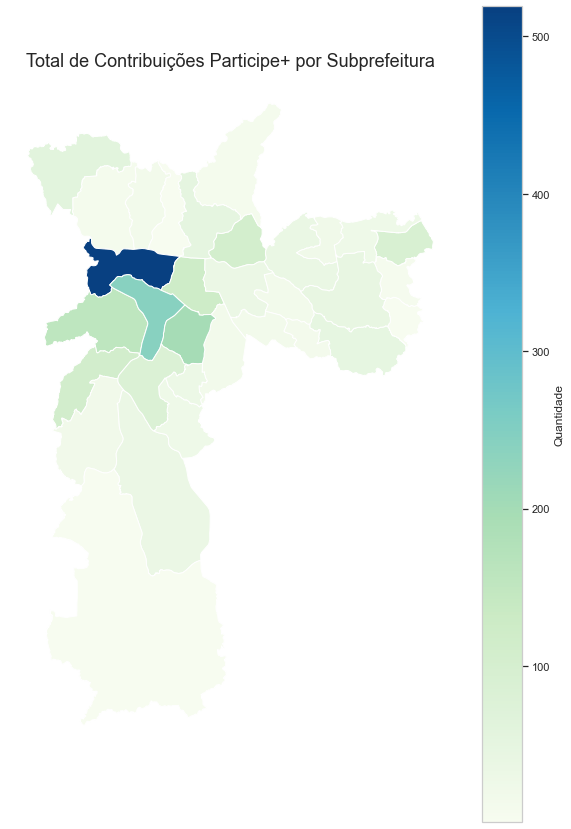

In [63]:
cmap_plot(subs, 'qtd_participe_mais_total', 'Total de Contribuições Participe+ por Subprefeitura')

In [64]:
subs['qtd_participe_mais_total_sem_lapa'] = subs['qtd_participe_mais_total']
#zerando o valor pra lapa
subs.loc[8, 'qtd_participe_mais_total_sem_lapa'] = 0

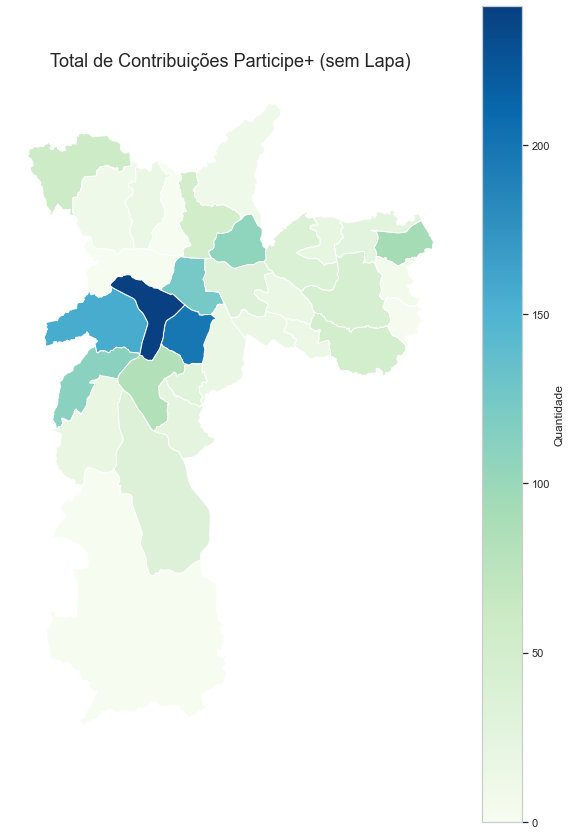

In [65]:
cmap_plot(subs, 'qtd_participe_mais_total_sem_lapa', 'Total de Contribuições Participe+ (sem Lapa)')